===== Diagnostic Information =====

IMU Data 'time_from_sync' Range:
Min: 790.0, Max: 920.0

GPS Data 'time_from_sync' Range:
Min: 790.0, Max: 919.001

Data Types:
IMU 'time_from_sync': float64
GPS 'time_from_sync': float64

Missing Values:
IMU 'time_from_sync' Missing: 0
GPS 'time_from_sync' Missing: 0


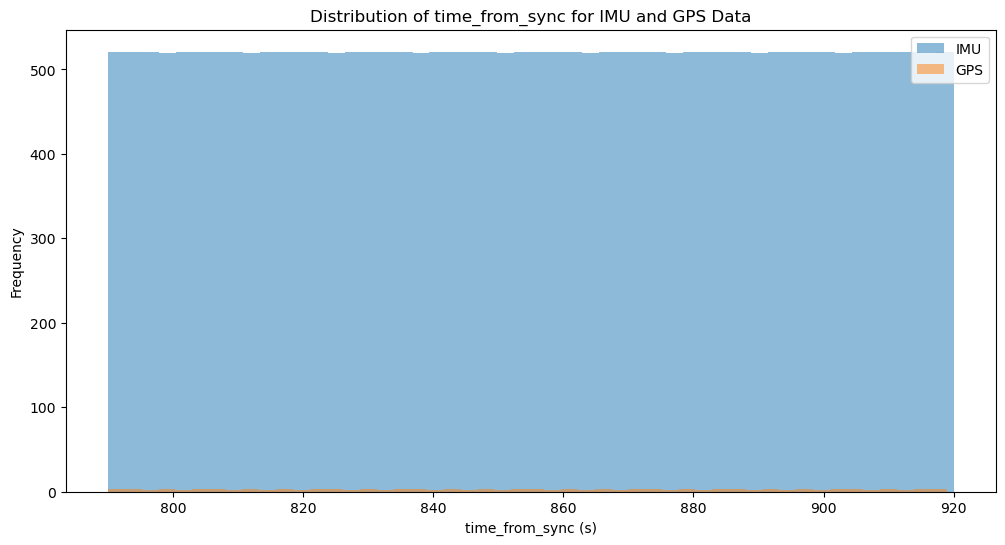


Overlapping 'time_from_sync' Range:
Min: 790.0, Max: 919.001
There is an overlapping 'time_from_sync' range between IMU and GPS data.

Number of rows in data_df after merge: 26001
data_df has data. Proceeding with further processing.

Calculated dt (s): 0.005000114440804282


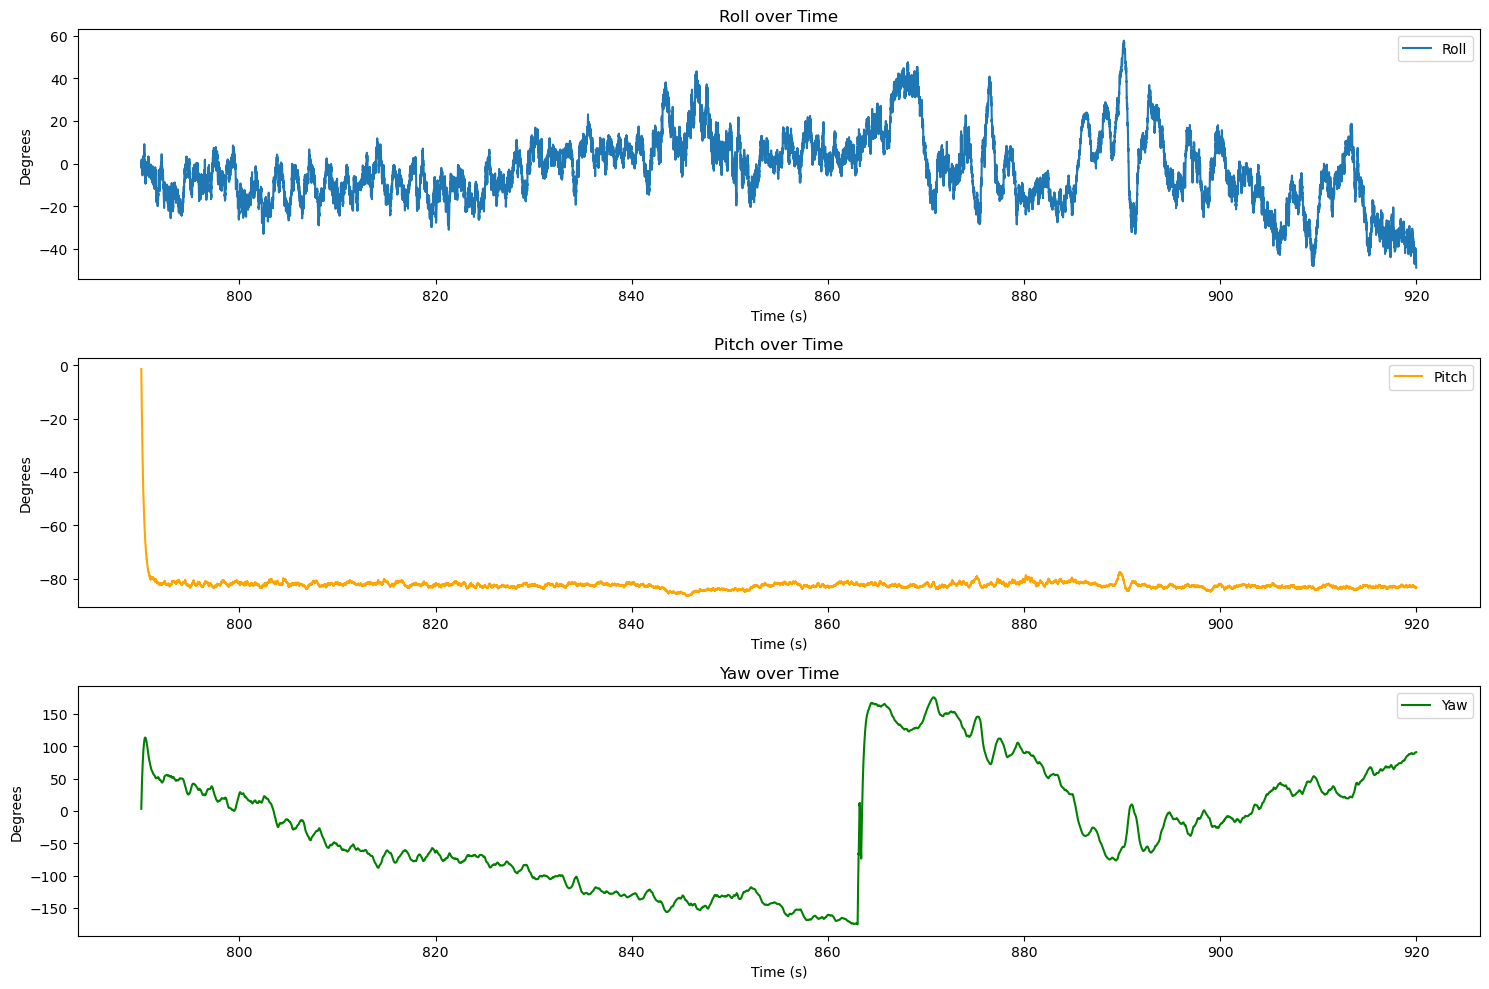

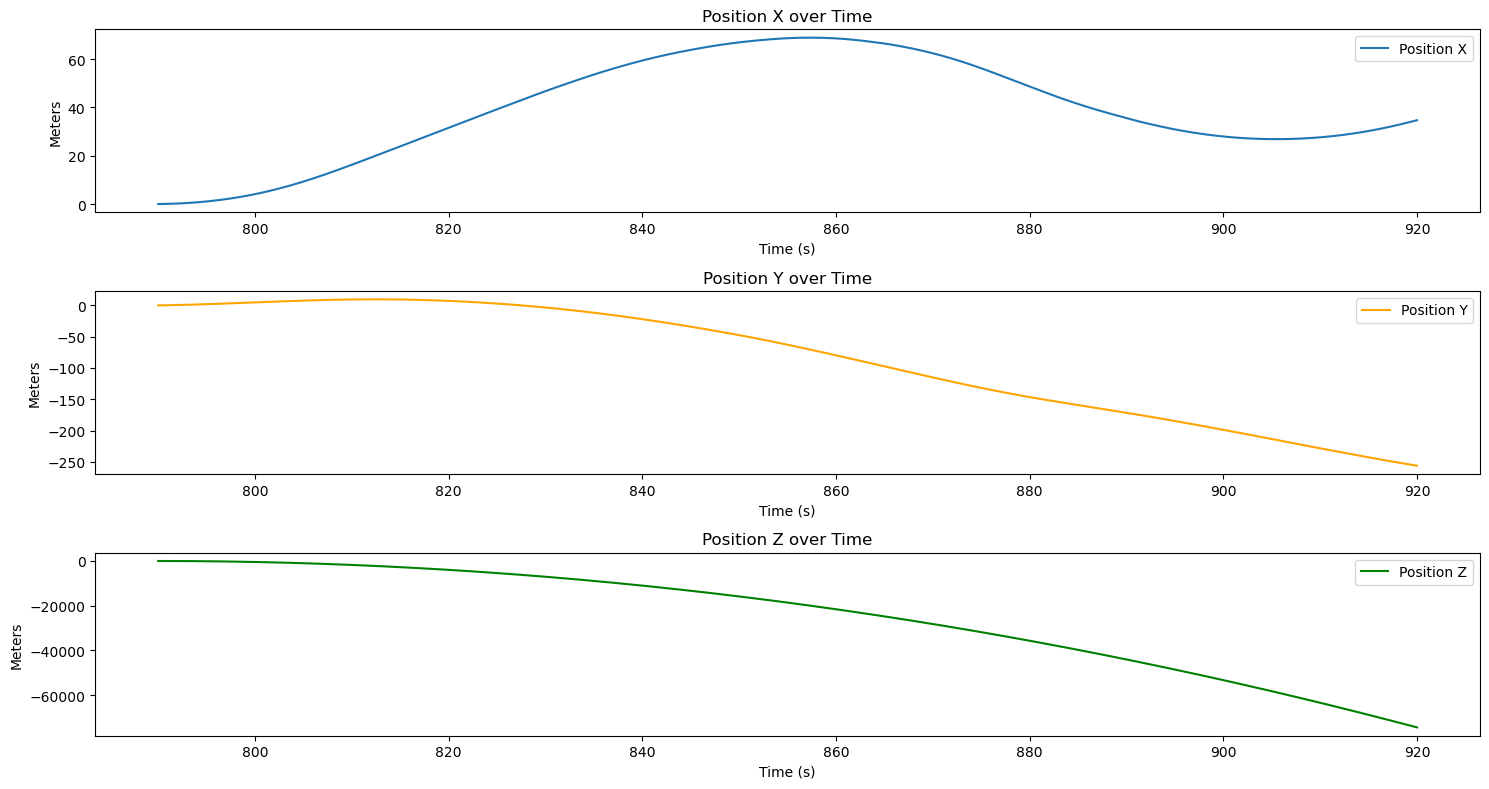

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Define file paths
BASE_DIR = '007_Fast_stbd_turn_1'
GPS_FILE = os.path.join(BASE_DIR, 'GPS', 'GPS_007_Fast_stbd_turn_1.csv')
IMU_DIR = os.path.join(BASE_DIR, 'IMU', 'Sensor_3')
ACCEL_FILE = os.path.join(IMU_DIR, 'accel_007_Fast_stbd_turn_1.csv')
ANGLE_FILE = os.path.join(IMU_DIR, 'angle_007_Fast_stbd_turn_1.csv')
GYRO_FILE = os.path.join(IMU_DIR, 'gyro_007_Fast_stbd_turn_1.csv')
MAG_FILE = os.path.join(IMU_DIR, 'mag_007_Fast_stbd_turn_1.csv')

# Load GPS data
gps_columns = ['Lat','Lng','Alt','Acc','Time','Prv','OrgLat','OrgLng','OrgAlt','OrgAcc',
              'Speed','Bearing','AdvPrv','Dly','Dst','AltOfst','Pressure',
              'PressureRef','RefAge','FromBT','Sats','Secs','AccDst','Quality',
              'PDOP','VDOP','HDOP','DGPSAge','DGPSStat','Category',
              'TimeWithTZ','TimeWithMS','DeviceTime','WriteTime',
              'SpeedKPH','SpeedMPH','Battery','time_from_sync']
gps_df = pd.read_csv(GPS_FILE, usecols=gps_columns)

# Load IMU data
imu_columns = ['t', 'x', 'y', 'z', 'time_from_sync']

# Function to load and preprocess IMU data
def load_imu_data(file_path, sensor_name):
    df = pd.read_csv(file_path, usecols=imu_columns)
    df = df.rename(columns={
        'x': f'{sensor_name}_x',
        'y': f'{sensor_name}_y',
        'z': f'{sensor_name}_z'
    })
    # Drop the 't' column to avoid duplication
    df = df.drop(columns=['t'])
    return df

accel_df = load_imu_data(ACCEL_FILE, 'accel')
angle_df = load_imu_data(ANGLE_FILE, 'angle')
gyro_df = load_imu_data(GYRO_FILE, 'gyro')
mag_df = load_imu_data(MAG_FILE, 'mag')

# Merge IMU data on time_from_sync
# Start with accel_df and iteratively merge other IMU dataframes
imu_df = accel_df.merge(gyro_df, on='time_from_sync', how='inner') \
                 .merge(mag_df, on='time_from_sync', how='inner') \
                 .merge(angle_df, on='time_from_sync', how='inner')

# Sort both IMU and GPS dataframes by 'time_from_sync'
imu_df_sorted = imu_df.sort_values('time_from_sync').reset_index(drop=True)
gps_df_sorted = gps_df.sort_values('time_from_sync').reset_index(drop=True)

# **Diagnostic Step 1: Check Time Ranges and Data Types**
print("===== Diagnostic Information =====\n")

# Time ranges
print("IMU Data 'time_from_sync' Range:")
print(f"Min: {imu_df_sorted['time_from_sync'].min()}, Max: {imu_df_sorted['time_from_sync'].max()}")

print("\nGPS Data 'time_from_sync' Range:")
print(f"Min: {gps_df_sorted['time_from_sync'].min()}, Max: {gps_df_sorted['time_from_sync'].max()}")

# Data types
print("\nData Types:")
print(f"IMU 'time_from_sync': {imu_df_sorted['time_from_sync'].dtype}")
print(f"GPS 'time_from_sync': {gps_df_sorted['time_from_sync'].dtype}")

# Check for missing values
print("\nMissing Values:")
print(f"IMU 'time_from_sync' Missing: {imu_df_sorted['time_from_sync'].isnull().sum()}")
print(f"GPS 'time_from_sync' Missing: {gps_df_sorted['time_from_sync'].isnull().sum()}")

# **Diagnostic Step 2: Visualize Overlap**
plt.figure(figsize=(12, 6))
plt.hist(imu_df_sorted['time_from_sync'], bins=50, alpha=0.5, label='IMU')
plt.hist(gps_df_sorted['time_from_sync'], bins=50, alpha=0.5, label='GPS')
plt.xlabel('time_from_sync (s)')
plt.ylabel('Frequency')
plt.title('Distribution of time_from_sync for IMU and GPS Data')
plt.legend()
plt.show()

# **Diagnostic Step 3: Check for Overlapping Time Range**
imu_min = imu_df_sorted['time_from_sync'].min()
imu_max = imu_df_sorted['time_from_sync'].max()
gps_min = gps_df_sorted['time_from_sync'].min()
gps_max = gps_df_sorted['time_from_sync'].max()

overlap_min = max(imu_min, gps_min)
overlap_max = min(imu_max, gps_max)

print(f"\nOverlapping 'time_from_sync' Range:")
print(f"Min: {overlap_min}, Max: {overlap_max}")

if overlap_min >= overlap_max:
    print("No overlapping 'time_from_sync' range between IMU and GPS data.")
else:
    print("There is an overlapping 'time_from_sync' range between IMU and GPS data.")

# **Diagnostic Step 4: Adjust Tolerance if Necessary**
# For illustration, let's assume we proceed with a larger tolerance
# You can adjust the tolerance based on your diagnostics
tolerance = 1.0  # seconds

# Perform the asof merge with the specified tolerance
data_df = pd.merge_asof(
    imu_df_sorted, 
    gps_df_sorted, 
    on='time_from_sync', 
    direction='nearest', 
    tolerance=tolerance
)

# Check if data_df is empty
print(f"\nNumber of rows in data_df after merge: {len(data_df)}")
if data_df.empty:
    print("data_df is empty after merging IMU and GPS data.")
    print("Possible reasons:")
    print("- No overlapping 'time_from_sync' within the specified tolerance.")
    print("- 'time_from_sync' units or formats differ between IMU and GPS data.")
    print("- Data ranges do not overlap.")
    print("\nSuggestions:")
    print("- Verify the 'time_from_sync' values and ensure they are in the same units.")
    print("- Increase the 'tolerance' parameter in the merge_asof function.")
    print("- Align the start times of IMU and GPS data if there's an offset.")
else:
    print("data_df has data. Proceeding with further processing.")

# If data_df is not empty, continue with processing
if not data_df.empty:
    # Drop rows with NaN values after merging (if any)
    # data_df.dropna(inplace=True)
    
    # Reset index after dropping rows
    data_df.reset_index(drop=True, inplace=True)
    
    # Initialize orientation (assuming starting at zero rotation)
    orientation = R.from_euler('xyz', [0, 0, 0], degrees=True)
    
    # Initialize lists to store orientation over time
    roll_list = []
    pitch_list = []
    yaw_list = []
    time_list = []
    
    # Complementary filter parameters
    alpha = 0.98
    # Calculate actual sampling rate based on time_from_sync
    # Calculate dt as the median difference between consecutive timestamps
    dt_series = data_df['time_from_sync'].diff()#.dropna()
    dt = dt_series.median()
    if pd.isna(dt) or dt <= 0:
        dt = 0.01  # fallback to default if dt is invalid
    
    print(f"\nCalculated dt (s): {dt}")
    
    for index, row in data_df.iterrows():
        # Gyroscope integration (degrees per second)
        gyro_rates = np.array([row['gyro_x'], row['gyro_y'], row['gyro_z']])
        delta_angle = gyro_rates * dt
        delta_rotation = R.from_euler('xyz', delta_angle, degrees=True)
        orientation = orientation * delta_rotation
    
        # Accelerometer angles
        accel = np.array([row['accel_x'], row['accel_y'], row['accel_z']])
        accel_norm = np.linalg.norm(accel)
        if accel_norm == 0:
            continue
        accel = accel / accel_norm
        accel_pitch = np.arcsin(-accel[0]) * (180 / np.pi)
        accel_roll = np.arctan2(accel[1], accel[2]) * (180 / np.pi)
    
        # Magnetometer yaw
        mag = np.array([row['mag_x'], row['mag_y'], row['mag_z']])
        mag_norm = np.linalg.norm(mag)
        if mag_norm == 0:
            continue
        mag = mag / mag_norm
        # Tilt compensation for magnetometer
        rot = orientation.as_euler('xyz', degrees=True)
        pitch_rad = np.deg2rad(rot[1])
        roll_rad = np.deg2rad(rot[0])
        mag_x_comp = mag[0] * np.cos(pitch_rad) + mag[1] * np.sin(roll_rad) * np.sin(pitch_rad) + mag[2] * np.cos(roll_rad) * np.sin(pitch_rad)
        mag_y_comp = mag[1] * np.cos(roll_rad) - mag[2] * np.sin(roll_rad)
        accel_yaw = np.arctan2(-mag_y_comp, mag_x_comp) * (180 / np.pi)
    
        # Complementary filter to combine gyro and accel/mag
        orientation_euler = orientation.as_euler('xyz', degrees=True)
        fused_roll = alpha * orientation_euler[0] + (1 - alpha) * accel_roll
        fused_pitch = alpha * orientation_euler[1] + (1 - alpha) * accel_pitch
        fused_yaw = alpha * orientation_euler[2] + (1 - alpha) * accel_yaw
        orientation = R.from_euler('xyz', [fused_roll, fused_pitch, fused_yaw], degrees=True)
    
        # Store the orientation directly into data_df
        data_df.at[index, 'roll'] = fused_roll
        data_df.at[index, 'pitch'] = fused_pitch
        data_df.at[index, 'yaw'] = fused_yaw
        time_list.append(row['time_from_sync'])
    
    # At this point, data_df contains 'roll', 'pitch', 'yaw' columns
    
    # Plot orientation over time
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(data_df['time_from_sync'], data_df['roll'], label='Roll')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Roll over Time')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(data_df['time_from_sync'], data_df['pitch'], label='Pitch', color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Pitch over Time')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(data_df['time_from_sync'], data_df['yaw'], label='Yaw', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Yaw over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Pose Estimation (Position)
    # Initialize position and velocity
    positions = []
    velocity = np.array([0.0, 0.0, 0.0])
    position = np.array([0.0, 0.0, 0.0])
    prev_time = data_df['time_from_sync'].iloc[0]
    
    for index, row in data_df.iterrows():
        current_time = row['time_from_sync']
        dt_pose = current_time - prev_time
        if dt_pose <= 0 or pd.isna(dt_pose):
            dt_pose = dt  # fallback to default
        prev_time = current_time
    
        # Get current orientation
        # Now 'roll', 'pitch', 'yaw' are available in data_df
        current_orientation = R.from_euler('xyz', [row['roll'], row['pitch'], row['yaw']], degrees=True)
        accel_body = np.array([row['accel_x'], row['accel_y'], row['accel_z']])
        # Assuming accelerometer measures in m/s^2. If not, convert accordingly.
        accel_global = current_orientation.apply(accel_body)
    
        # Subtract gravity (assuming gravity is along Z-axis in global frame)
        gravity = np.array([0, 0, 9.81])  # m/s^2
        accel_global_no_gravity = accel_global - gravity
    
        # Integrate acceleration to get velocity
        velocity += accel_global_no_gravity * dt_pose
    
        # Integrate velocity to get position
        position += velocity * dt_pose
    
        positions.append(position.copy())
    
    positions = np.array(positions)
    data_df['pos_x'] = positions[:,0]
    data_df['pos_y'] = positions[:,1]
    data_df['pos_z'] = positions[:,2]
    
    # Plot Position over Time
    plt.figure(figsize=(15, 8))
    
    plt.subplot(3,1,1)
    plt.plot(data_df['time_from_sync'], data_df['pos_x'], label='Position X')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position X over Time')
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.plot(data_df['time_from_sync'], data_df['pos_y'], label='Position Y', color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position Y over Time')
    plt.legend()
    
    plt.subplot(3,1,3)
    plt.plot(data_df['time_from_sync'], data_df['pos_z'], label='Position Z', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position Z over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


===== Diagnostic Information =====

IMU Data 'time_from_sync' Range:
Min: 790.0, Max: 920.0

GPS Data 'time_from_sync' Range:
Min: 790.0, Max: 919.001

Data Types:
IMU 'time_from_sync': float64
GPS 'time_from_sync': float64

Missing Values:
IMU 'time_from_sync' Missing: 0
GPS 'time_from_sync' Missing: 0


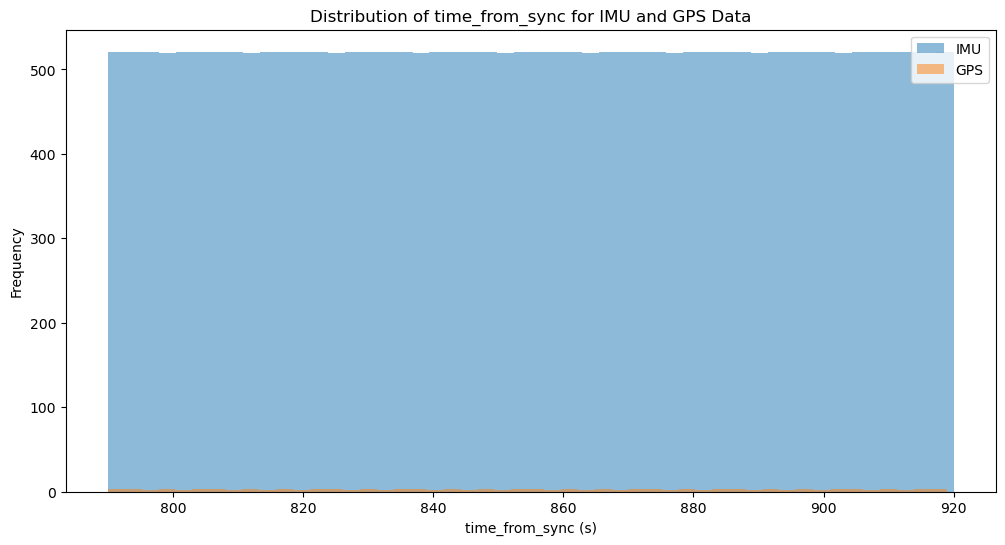


Overlapping 'time_from_sync' Range:
Min: 790.0, Max: 919.001
There is an overlapping 'time_from_sync' range between IMU and GPS data.

Number of rows in data_df after merge: 26001
data_df has data. Proceeding with further processing.

Calculated dt (s): 0.005000114440804282


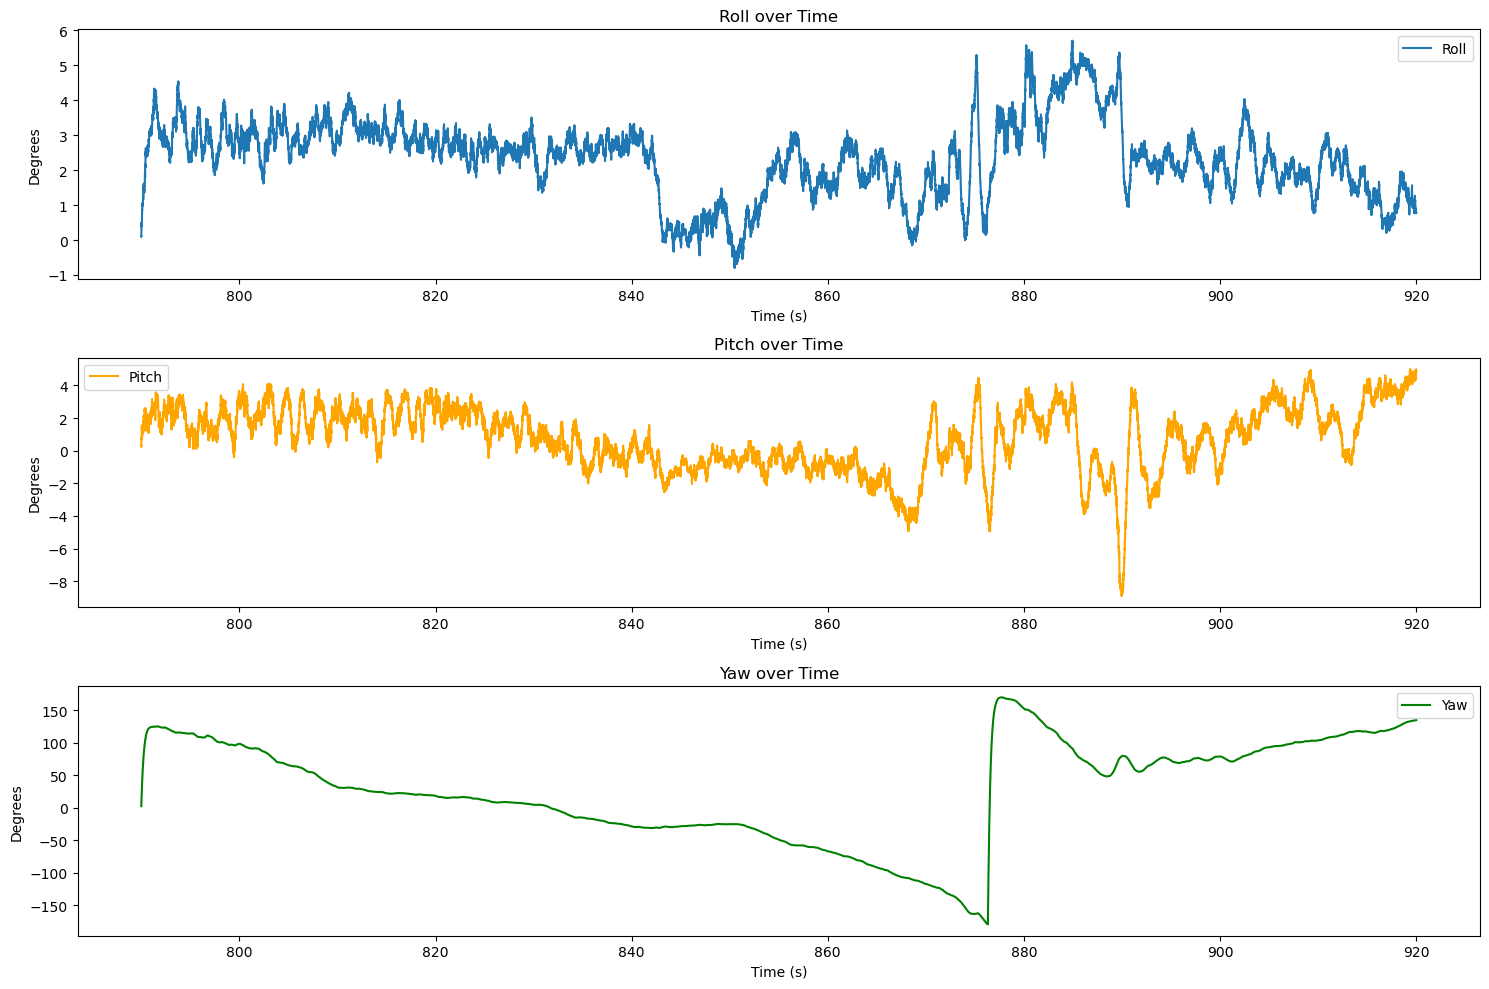

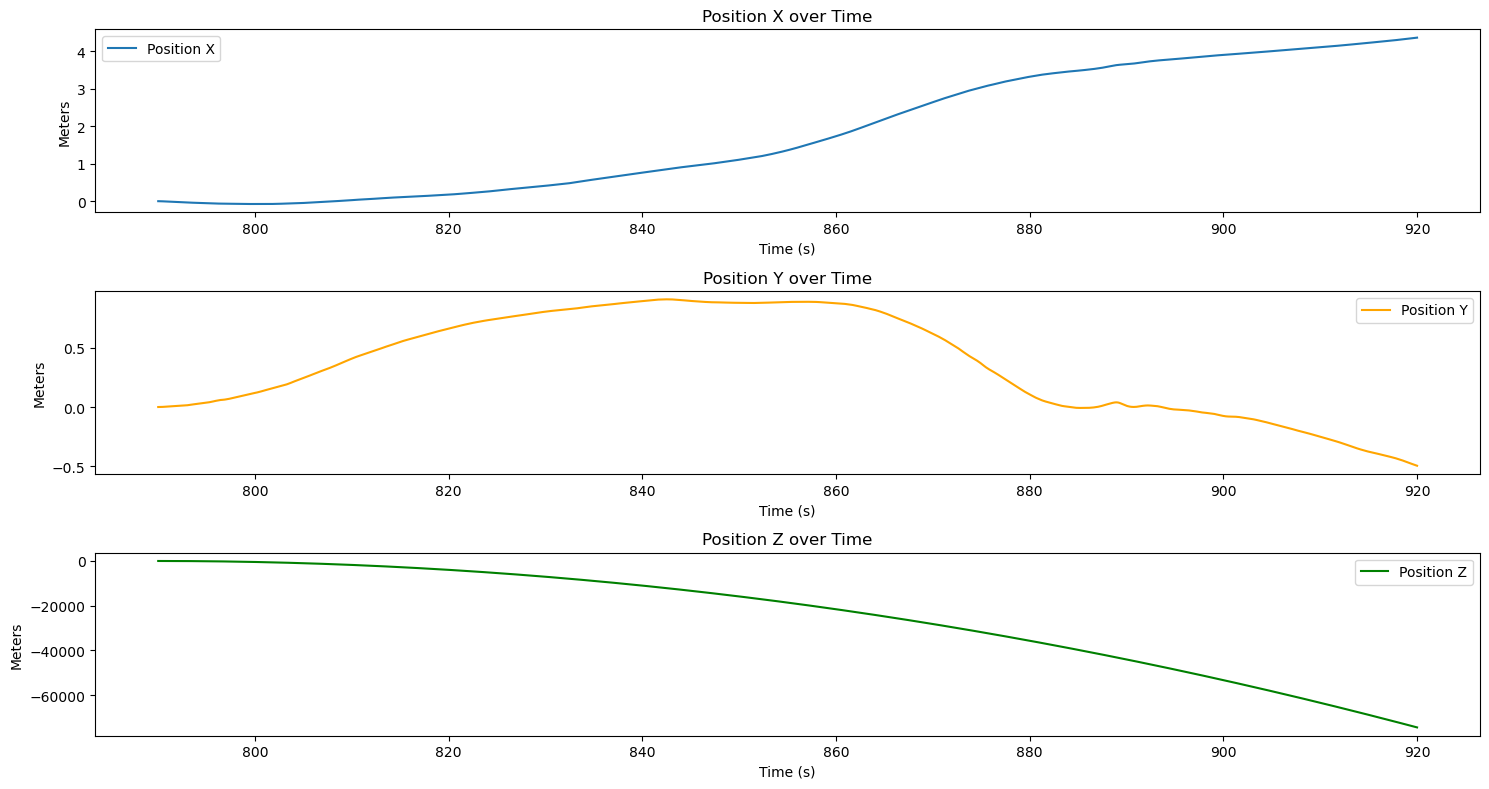

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Define file paths
BASE_DIR = '007_Fast_stbd_turn_1'
GPS_FILE = os.path.join(BASE_DIR, 'GPS', 'GPS_007_Fast_stbd_turn_1.csv')
IMU_DIR = os.path.join(BASE_DIR, 'IMU', 'Sensor_3')
ACCEL_FILE = os.path.join(IMU_DIR, 'accel_007_Fast_stbd_turn_1.csv')
ANGLE_FILE = os.path.join(IMU_DIR, 'angle_007_Fast_stbd_turn_1.csv')
GYRO_FILE = os.path.join(IMU_DIR, 'gyro_007_Fast_stbd_turn_1.csv')
MAG_FILE = os.path.join(IMU_DIR, 'mag_007_Fast_stbd_turn_1.csv')

# Load GPS data
gps_columns = ['Lat','Lng','Alt','Acc','Time','Prv','OrgLat','OrgLng','OrgAlt','OrgAcc',
              'Speed','Bearing','AdvPrv','Dly','Dst','AltOfst','Pressure',
              'PressureRef','RefAge','FromBT','Sats','Secs','AccDst','Quality',
              'PDOP','VDOP','HDOP','DGPSAge','DGPSStat','Category',
              'TimeWithTZ','TimeWithMS','DeviceTime','WriteTime',
              'SpeedKPH','SpeedMPH','Battery','time_from_sync']
gps_df = pd.read_csv(GPS_FILE, usecols=gps_columns)

# Load IMU data
imu_columns = ['t', 'x', 'y', 'z', 'time_from_sync']

# Function to load and preprocess IMU data
def load_imu_data(file_path, sensor_name):
    df = pd.read_csv(file_path, usecols=imu_columns)
    df = df.rename(columns={
        'x': f'{sensor_name}_x',
        'y': f'{sensor_name}_y',
        'z': f'{sensor_name}_z'
    })
    # Drop the 't' column to avoid duplication
    df = df.drop(columns=['t'])
    return df

accel_df = load_imu_data(ACCEL_FILE, 'accel')
angle_df = load_imu_data(ANGLE_FILE, 'angle')
gyro_df = load_imu_data(GYRO_FILE, 'gyro')
mag_df = load_imu_data(MAG_FILE, 'mag')

# Merge IMU data on time_from_sync
imu_df = accel_df.merge(gyro_df, on='time_from_sync', how='inner') \
                 .merge(mag_df, on='time_from_sync', how='inner') \
                 .merge(angle_df, on='time_from_sync', how='inner')

# Sort both IMU and GPS dataframes by 'time_from_sync'
imu_df_sorted = imu_df.sort_values('time_from_sync').reset_index(drop=True)
gps_df_sorted = gps_df.sort_values('time_from_sync').reset_index(drop=True)

# **Diagnostic Step 1: Check Time Ranges and Data Types**
print("===== Diagnostic Information =====\n")

# Time ranges
print("IMU Data 'time_from_sync' Range:")
print(f"Min: {imu_df_sorted['time_from_sync'].min()}, Max: {imu_df_sorted['time_from_sync'].max()}")

print("\nGPS Data 'time_from_sync' Range:")
print(f"Min: {gps_df_sorted['time_from_sync'].min()}, Max: {gps_df_sorted['time_from_sync'].max()}")

# Data types
print("\nData Types:")
print(f"IMU 'time_from_sync': {imu_df_sorted['time_from_sync'].dtype}")
print(f"GPS 'time_from_sync': {gps_df_sorted['time_from_sync'].dtype}")

# Check for missing values
print("\nMissing Values:")
print(f"IMU 'time_from_sync' Missing: {imu_df_sorted['time_from_sync'].isnull().sum()}")
print(f"GPS 'time_from_sync' Missing: {gps_df_sorted['time_from_sync'].isnull().sum()}")

# **Diagnostic Step 2: Visualize Overlap**
plt.figure(figsize=(12, 6))
plt.hist(imu_df_sorted['time_from_sync'], bins=50, alpha=0.5, label='IMU')
plt.hist(gps_df_sorted['time_from_sync'], bins=50, alpha=0.5, label='GPS')
plt.xlabel('time_from_sync (s)')
plt.ylabel('Frequency')
plt.title('Distribution of time_from_sync for IMU and GPS Data')
plt.legend()
plt.show()

# **Diagnostic Step 3: Check for Overlapping Time Range**
imu_min = imu_df_sorted['time_from_sync'].min()
imu_max = imu_df_sorted['time_from_sync'].max()
gps_min = gps_df_sorted['time_from_sync'].min()
gps_max = gps_df_sorted['time_from_sync'].max()

overlap_min = max(imu_min, gps_min)
overlap_max = min(imu_max, gps_max)

print(f"\nOverlapping 'time_from_sync' Range:")
print(f"Min: {overlap_min}, Max: {overlap_max}")

if overlap_min >= overlap_max:
    print("No overlapping 'time_from_sync' range between IMU and GPS data.")
else:
    print("There is an overlapping 'time_from_sync' range between IMU and GPS data.")

# **Diagnostic Step 4: Adjust Tolerance if Necessary**
# For illustration, let's proceed with a larger tolerance
tolerance = 1.0  # seconds

# Perform the asof merge with the specified tolerance
data_df = pd.merge_asof(
    imu_df_sorted, 
    gps_df_sorted, 
    on='time_from_sync', 
    direction='nearest', 
    tolerance=tolerance
)

# Check if data_df is empty
print(f"\nNumber of rows in data_df after merge: {len(data_df)}")
if data_df.empty:
    print("data_df is empty after merging IMU and GPS data.")
    print("Possible reasons:")
    print("- No overlapping 'time_from_sync' within the specified tolerance.")
    print("- 'time_from_sync' units or formats differ between IMU and GPS data.")
    print("- Data ranges do not overlap.")
    print("\nSuggestions:")
    print("- Verify the 'time_from_sync' values and ensure they are in the same units.")
    print("- Increase the 'tolerance' parameter in the merge_asof function.")
    print("- Align the start times of IMU and GPS data if there's an offset.")
else:
    print("data_df has data. Proceeding with further processing.")

# If data_df is not empty, continue with processing
if not data_df.empty:
    # Drop rows with NaN values after merging (if any)
    # data_df.dropna(inplace=True)
    
    # Reset index after dropping rows
    data_df.reset_index(drop=True, inplace=True)
    
    # Initialize orientation (assuming starting at zero rotation)
    orientation = R.from_euler('xyz', [0, 0, 0], degrees=True)
    
    # Initialize lists to store orientation over time
    roll_list = []
    pitch_list = []
    yaw_list = []
    time_list = []
    
    # Define the transformation matrix to map IMU axes to Body frame
    # IMU +X (Upward) -> Body +Z (Upward)
    # IMU +Y (Forward) -> Body +X (Forward)
    # IMU +Z (Port)    -> Body +Y (Port)
    transformation_matrix = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]
    ])
    
    # Complementary filter parameters
    alpha = 0.98
    # Calculate actual sampling rate based on time_from_sync
    # Calculate dt as the median difference between consecutive timestamps
    dt_series = data_df['time_from_sync'].diff()#.dropna()
    dt = dt_series.median()
    if pd.isna(dt) or dt <= 0:
        dt = 0.01  # fallback to default if dt is invalid
    
    print(f"\nCalculated dt (s): {dt}")
    
    for index, row in data_df.iterrows():
        # Apply the transformation to IMU data to align with Body frame
        accel_body = transformation_matrix @ np.array([row['accel_x'], row['accel_y'], row['accel_z']])
        gyro_body = transformation_matrix @ np.array([row['gyro_x'], row['gyro_y'], row['gyro_z']])
        mag_body = transformation_matrix @ np.array([row['mag_x'], row['mag_y'], row['mag_z']])
        
        # Gyroscope integration (degrees per second)
        delta_angle = gyro_body * dt
        delta_rotation = R.from_euler('xyz', delta_angle, degrees=True)
        orientation = orientation * delta_rotation

        # Accelerometer angles
        accel_norm = np.linalg.norm(accel_body)
        if accel_norm == 0:
            continue
        accel_normalized = accel_body / accel_norm
        accel_pitch = np.arcsin(-accel_normalized[0]) * (180 / np.pi)
        accel_roll = np.arctan2(accel_normalized[1], accel_normalized[2]) * (180 / np.pi)

        # Magnetometer yaw
        mag_norm = np.linalg.norm(mag_body)
        if mag_norm == 0:
            continue
        mag_normalized = mag_body / mag_norm
        # Tilt compensation for magnetometer
        rot_euler = orientation.as_euler('xyz', degrees=True)
        pitch_rad = np.deg2rad(rot_euler[1])
        roll_rad = np.deg2rad(rot_euler[0])
        mag_x_comp = mag_normalized[0] * np.cos(pitch_rad) + mag_normalized[1] * np.sin(roll_rad) * np.sin(pitch_rad) + mag_normalized[2] * np.cos(roll_rad) * np.sin(pitch_rad)
        mag_y_comp = mag_normalized[1] * np.cos(roll_rad) - mag_normalized[2] * np.sin(roll_rad)
        accel_yaw = np.arctan2(-mag_y_comp, mag_x_comp) * (180 / np.pi)

        # Complementary filter to combine gyro and accel/mag
        orientation_euler = orientation.as_euler('xyz', degrees=True)
        fused_roll = alpha * orientation_euler[0] + (1 - alpha) * accel_roll
        fused_pitch = alpha * orientation_euler[1] + (1 - alpha) * accel_pitch
        fused_yaw = alpha * orientation_euler[2] + (1 - alpha) * accel_yaw
        orientation = R.from_euler('xyz', [fused_roll, fused_pitch, fused_yaw], degrees=True)

        # Store the orientation directly into data_df
        data_df.at[index, 'roll'] = fused_roll
        data_df.at[index, 'pitch'] = fused_pitch
        data_df.at[index, 'yaw'] = fused_yaw

    # At this point, data_df contains 'roll', 'pitch', 'yaw' columns

    # Plot orientation over time
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(data_df['time_from_sync'], data_df['roll'], label='Roll')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Roll over Time')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(data_df['time_from_sync'], data_df['pitch'], label='Pitch', color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Pitch over Time')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(data_df['time_from_sync'], data_df['yaw'], label='Yaw', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Yaw over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Pose Estimation (Position)
    # Initialize position and velocity
    positions = []
    velocity = np.array([0.0, 0.0, 0.0])
    position = np.array([0.0, 0.0, 0.0])
    prev_time = data_df['time_from_sync'].iloc[0]
    
    for index, row in data_df.iterrows():
        current_time = row['time_from_sync']
        dt_pose = current_time - prev_time
        if dt_pose <= 0 or pd.isna(dt_pose):
            dt_pose = dt  # fallback to default
        prev_time = current_time

        # Get current orientation
        # 'roll', 'pitch', 'yaw' are available in data_df
        current_orientation = R.from_euler('xyz', [row['roll'], row['pitch'], row['yaw']], degrees=True)
        accel_body_transformed = transformation_matrix @ np.array([row['accel_x'], row['accel_y'], row['accel_z']])
        accel_global = current_orientation.apply(accel_body_transformed)

        # Subtract gravity (assuming gravity is along Z-axis in global frame)
        gravity = np.array([0, 0, 9.81])  # m/s^2
        accel_global_no_gravity = accel_global - gravity

        # Integrate acceleration to get velocity
        velocity += accel_global_no_gravity * dt_pose

        # Integrate velocity to get position
        position += velocity * dt_pose

        positions.append(position.copy())

    positions = np.array(positions)
    data_df['pos_x'] = positions[:,0]
    data_df['pos_y'] = positions[:,1]
    data_df['pos_z'] = positions[:,2]

    # Plot Position over Time
    plt.figure(figsize=(15, 8))
    
    plt.subplot(3,1,1)
    plt.plot(data_df['time_from_sync'], data_df['pos_x'], label='Position X')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position X over Time')
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.plot(data_df['time_from_sync'], data_df['pos_y'], label='Position Y', color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position Y over Time')
    plt.legend()
    
    plt.subplot(3,1,3)
    plt.plot(data_df['time_from_sync'], data_df['pos_z'], label='Position Z', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position Z over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


===== Diagnostic Information =====

IMU Data 'time_from_sync' Range:
Min: 790.0, Max: 920.0

GPS Data 'time_from_sync' Range:
Min: 790.0, Max: 919.001

Data Types:
IMU 'time_from_sync': float64
GPS 'time_from_sync': float64

Missing Values:
IMU 'time_from_sync' Missing: 0
GPS 'time_from_sync' Missing: 0


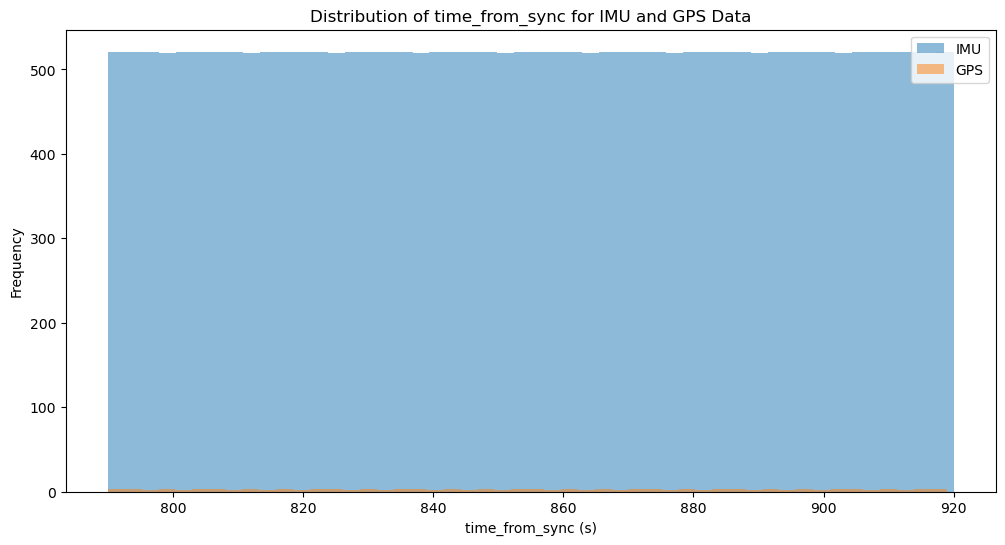


Overlapping 'time_from_sync' Range:
Min: 790.0, Max: 919.001
There is an overlapping 'time_from_sync' range between IMU and GPS data.

Number of rows in data_df after merge: 26001
data_df has data. Proceeding with further processing.

Calculated dt (s): 0.005000114440804282


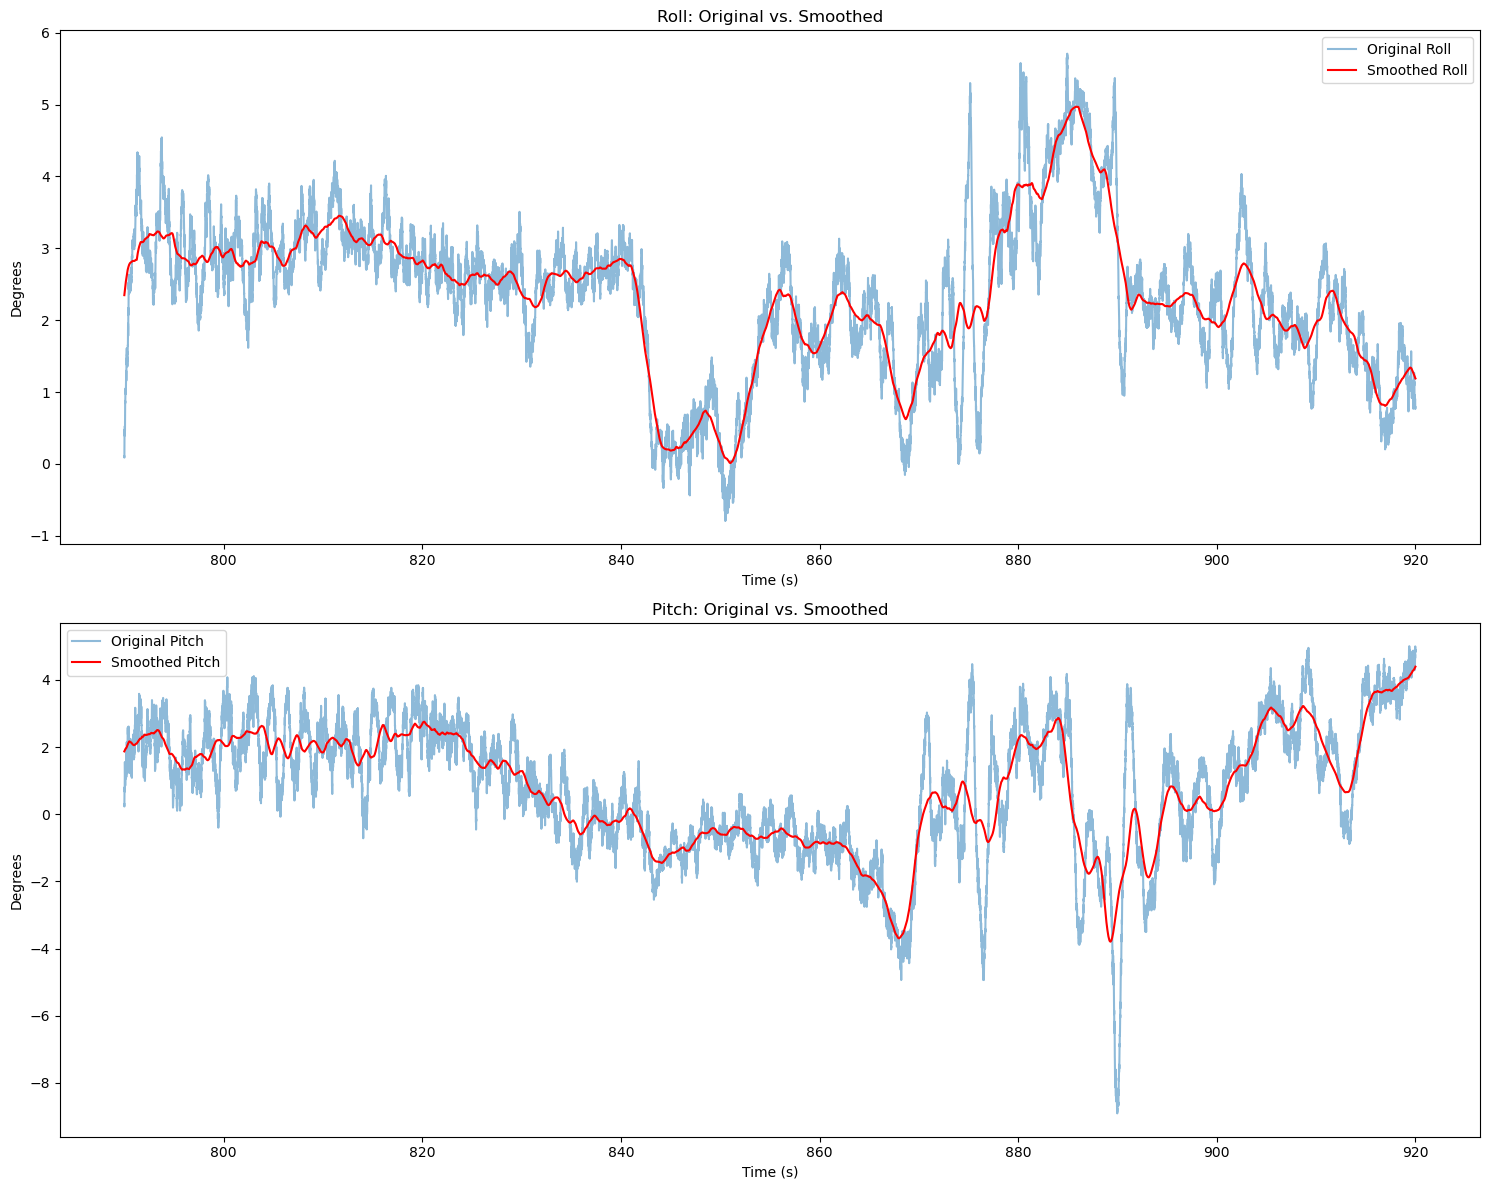

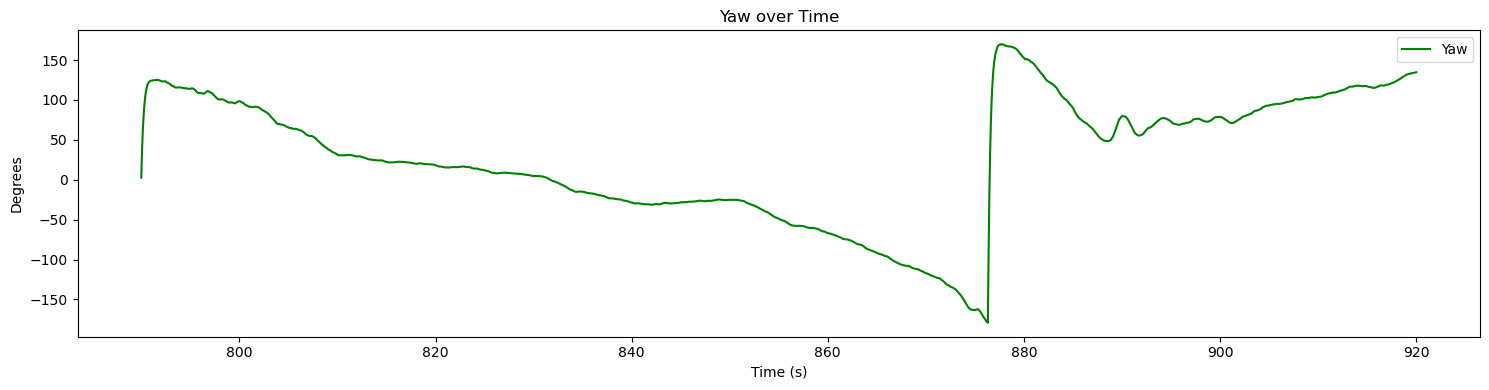

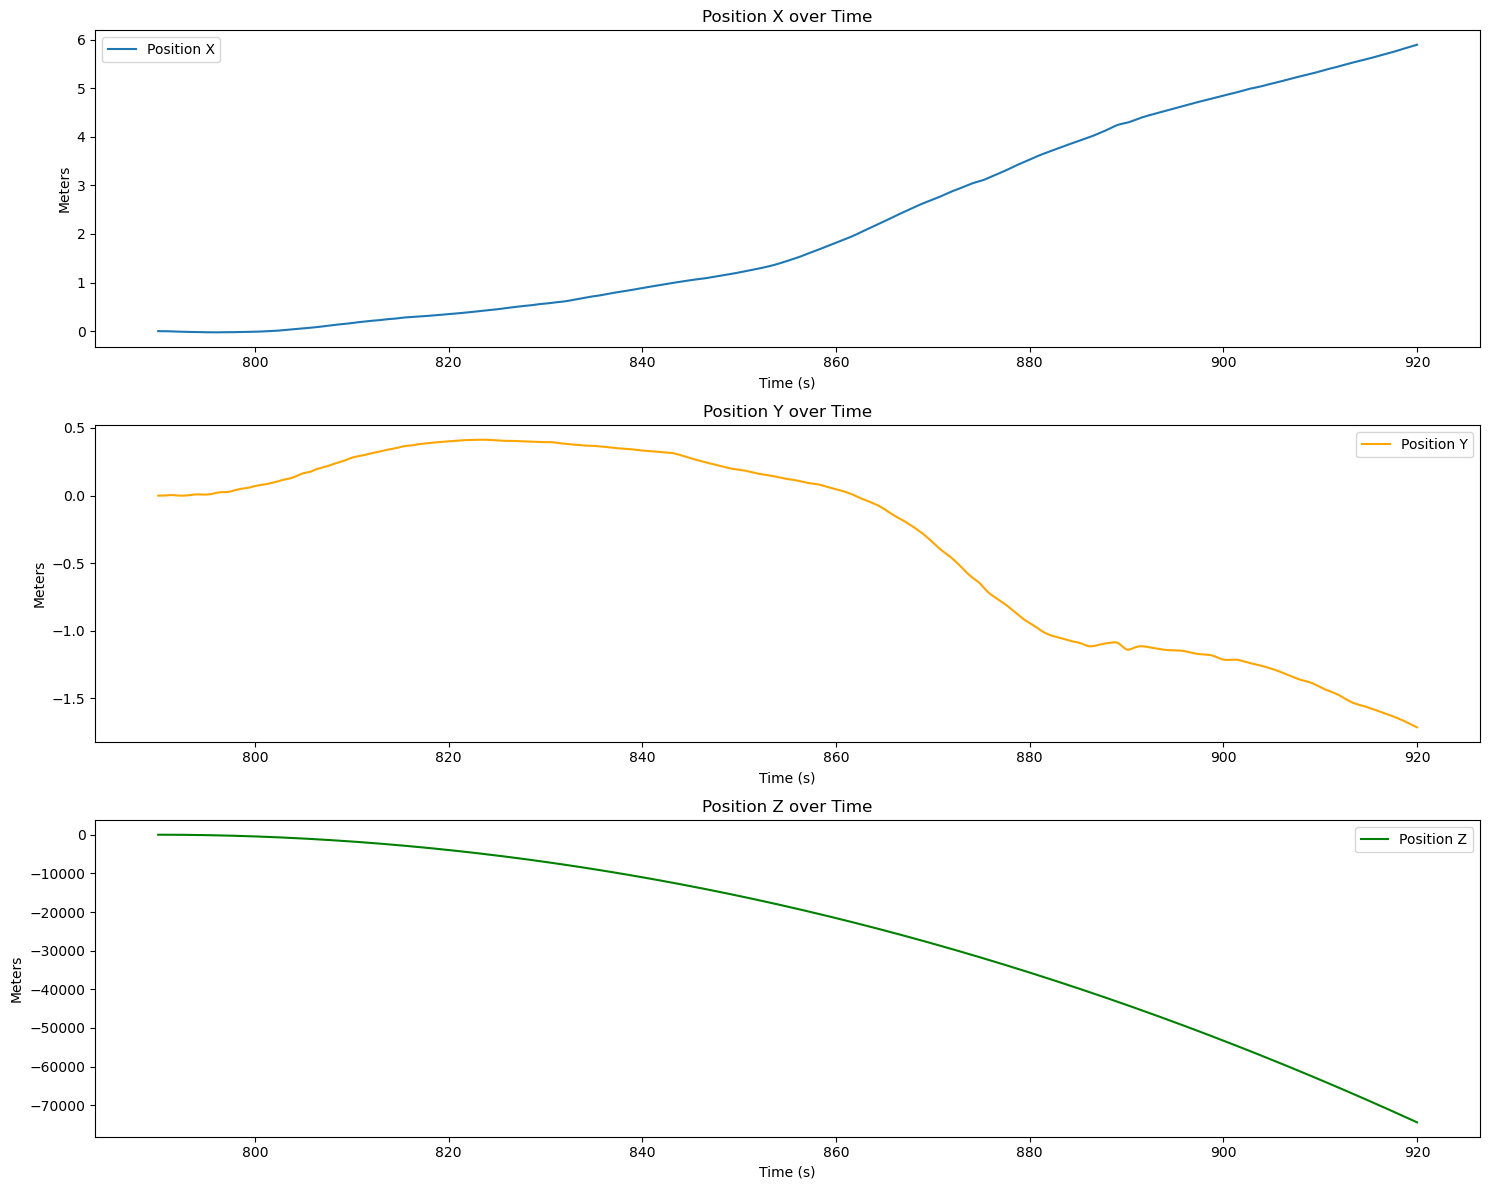

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Define file paths
BASE_DIR = '007_Fast_stbd_turn_1'
GPS_FILE = os.path.join(BASE_DIR, 'GPS', 'GPS_007_Fast_stbd_turn_1.csv')
IMU_DIR = os.path.join(BASE_DIR, 'IMU', 'Sensor_3')
ACCEL_FILE = os.path.join(IMU_DIR, 'accel_007_Fast_stbd_turn_1.csv')
ANGLE_FILE = os.path.join(IMU_DIR, 'angle_007_Fast_stbd_turn_1.csv')
GYRO_FILE = os.path.join(IMU_DIR, 'gyro_007_Fast_stbd_turn_1.csv')
MAG_FILE = os.path.join(IMU_DIR, 'mag_007_Fast_stbd_turn_1.csv')

# Load GPS data
gps_columns = ['Lat','Lng','Alt','Acc','Time','Prv','OrgLat','OrgLng','OrgAlt','OrgAcc',
              'Speed','Bearing','AdvPrv','Dly','Dst','AltOfst','Pressure',
              'PressureRef','RefAge','FromBT','Sats','Secs','AccDst','Quality',
              'PDOP','VDOP','HDOP','DGPSAge','DGPSStat','Category',
              'TimeWithTZ','TimeWithMS','DeviceTime','WriteTime',
              'SpeedKPH','SpeedMPH','Battery','time_from_sync']
gps_df = pd.read_csv(GPS_FILE, usecols=gps_columns)

# Load IMU data
imu_columns = ['t', 'x', 'y', 'z', 'time_from_sync']

# Function to load and preprocess IMU data
def load_imu_data(file_path, sensor_name):
    df = pd.read_csv(file_path, usecols=imu_columns)
    df = df.rename(columns={
        'x': f'{sensor_name}_x',
        'y': f'{sensor_name}_y',
        'z': f'{sensor_name}_z'
    })
    # Drop the 't' column to avoid duplication
    df = df.drop(columns=['t'])
    return df

accel_df = load_imu_data(ACCEL_FILE, 'accel')
angle_df = load_imu_data(ANGLE_FILE, 'angle')
gyro_df = load_imu_data(GYRO_FILE, 'gyro')
mag_df = load_imu_data(MAG_FILE, 'mag')

# Merge IMU data on time_from_sync
imu_df = accel_df.merge(gyro_df, on='time_from_sync', how='inner') \
                 .merge(mag_df, on='time_from_sync', how='inner') \
                 .merge(angle_df, on='time_from_sync', how='inner')

# Sort both IMU and GPS dataframes by 'time_from_sync'
imu_df_sorted = imu_df.sort_values('time_from_sync').reset_index(drop=True)
gps_df_sorted = gps_df.sort_values('time_from_sync').reset_index(drop=True)

# **Diagnostic Step 1: Check Time Ranges and Data Types**
print("===== Diagnostic Information =====\n")

# Time ranges
print("IMU Data 'time_from_sync' Range:")
print(f"Min: {imu_df_sorted['time_from_sync'].min()}, Max: {imu_df_sorted['time_from_sync'].max()}")

print("\nGPS Data 'time_from_sync' Range:")
print(f"Min: {gps_df_sorted['time_from_sync'].min()}, Max: {gps_df_sorted['time_from_sync'].max()}")

# Data types
print("\nData Types:")
print(f"IMU 'time_from_sync': {imu_df_sorted['time_from_sync'].dtype}")
print(f"GPS 'time_from_sync': {gps_df_sorted['time_from_sync'].dtype}")

# Check for missing values
print("\nMissing Values:")
print(f"IMU 'time_from_sync' Missing: {imu_df_sorted['time_from_sync'].isnull().sum()}")
print(f"GPS 'time_from_sync' Missing: {gps_df_sorted['time_from_sync'].isnull().sum()}")

# **Diagnostic Step 2: Visualize Overlap**
plt.figure(figsize=(12, 6))
plt.hist(imu_df_sorted['time_from_sync'], bins=50, alpha=0.5, label='IMU')
plt.hist(gps_df_sorted['time_from_sync'], bins=50, alpha=0.5, label='GPS')
plt.xlabel('time_from_sync (s)')
plt.ylabel('Frequency')
plt.title('Distribution of time_from_sync for IMU and GPS Data')
plt.legend()
plt.show()

# **Diagnostic Step 3: Check for Overlapping Time Range**
imu_min = imu_df_sorted['time_from_sync'].min()
imu_max = imu_df_sorted['time_from_sync'].max()
gps_min = gps_df_sorted['time_from_sync'].min()
gps_max = gps_df_sorted['time_from_sync'].max()

overlap_min = max(imu_min, gps_min)
overlap_max = min(imu_max, gps_max)

print(f"\nOverlapping 'time_from_sync' Range:")
print(f"Min: {overlap_min}, Max: {overlap_max}")

if overlap_min >= overlap_max:
    print("No overlapping 'time_from_sync' range between IMU and GPS data.")
else:
    print("There is an overlapping 'time_from_sync' range between IMU and GPS data.")

# **Diagnostic Step 4: Adjust Tolerance if Necessary**
# For illustration, let's proceed with a larger tolerance
tolerance = 1.0  # seconds

# Perform the asof merge with the specified tolerance
data_df = pd.merge_asof(
    imu_df_sorted, 
    gps_df_sorted, 
    on='time_from_sync', 
    direction='nearest', 
    tolerance=tolerance
)

# Check if data_df is empty
print(f"\nNumber of rows in data_df after merge: {len(data_df)}")
if data_df.empty:
    print("data_df is empty after merging IMU and GPS data.")
    print("Possible reasons:")
    print("- No overlapping 'time_from_sync' within the specified tolerance.")
    print("- 'time_from_sync' units or formats differ between IMU and GPS data.")
    print("- Data ranges do not overlap.")
    print("\nSuggestions:")
    print("- Verify the 'time_from_sync' values and ensure they are in the same units.")
    print("- Increase the 'tolerance' parameter in the merge_asof function.")
    print("- Align the start times of IMU and GPS data if there's an offset.")
else:
    print("data_df has data. Proceeding with further processing.")

# If data_df is not empty, continue with processing
if not data_df.empty:
    # Drop rows with NaN values after merging (if any)
    # data_df.dropna(inplace=True)
    
    # Reset index after dropping rows
    data_df.reset_index(drop=True, inplace=True)
    
    # Initialize orientation (assuming starting at zero rotation)
    orientation = R.from_euler('xyz', [0, 0, 0], degrees=True)
    
    # Initialize lists to store orientation over time
    time_list = []
    
    # Define the transformation matrix to map IMU axes to Body frame
    # IMU +X (Upward) -> Body +Z (Upward)
    # IMU +Y (Forward) -> Body +X (Forward)
    # IMU +Z (Port)    -> Body +Y (Port)
    transformation_matrix = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]
    ])
    
    # Complementary filter parameters
    alpha = 0.98
    # Calculate actual sampling rate based on time_from_sync
    # Calculate dt as the median difference between consecutive timestamps
    dt_series = data_df['time_from_sync'].diff()#.dropna()
    dt = dt_series.median()
    if pd.isna(dt) or dt <= 0:
        dt = 0.01  # fallback to default if dt is invalid
    
    print(f"\nCalculated dt (s): {dt}")
    
    for index, row in data_df.iterrows():
        # Apply the transformation to IMU data to align with Body frame
        accel_body = transformation_matrix @ np.array([row['accel_x'], row['accel_y'], row['accel_z']])
        gyro_body = transformation_matrix @ np.array([row['gyro_x'], row['gyro_y'], row['gyro_z']])
        mag_body = transformation_matrix @ np.array([row['mag_x'], row['mag_y'], row['mag_z']])
        
        # Gyroscope integration (degrees per second)
        delta_angle = gyro_body * dt
        delta_rotation = R.from_euler('xyz', delta_angle, degrees=True)
        orientation = orientation * delta_rotation

        # Accelerometer angles
        accel_norm = np.linalg.norm(accel_body)
        if accel_norm == 0:
            continue
        accel_normalized = accel_body / accel_norm
        accel_pitch = np.arcsin(-accel_normalized[0]) * (180 / np.pi)
        accel_roll = np.arctan2(accel_normalized[1], accel_normalized[2]) * (180 / np.pi)

        # Magnetometer yaw
        mag_norm = np.linalg.norm(mag_body)
        if mag_norm == 0:
            continue
        mag_normalized = mag_body / mag_norm
        # Tilt compensation for magnetometer
        rot_euler = orientation.as_euler('xyz', degrees=True)
        pitch_rad = np.deg2rad(rot_euler[1])
        roll_rad = np.deg2rad(rot_euler[0])
        mag_x_comp = mag_normalized[0] * np.cos(pitch_rad) + mag_normalized[1] * np.sin(roll_rad) * np.sin(pitch_rad) + mag_normalized[2] * np.cos(roll_rad) * np.sin(pitch_rad)
        mag_y_comp = mag_normalized[1] * np.cos(roll_rad) - mag_normalized[2] * np.sin(roll_rad)
        accel_yaw = np.arctan2(-mag_y_comp, mag_x_comp) * (180 / np.pi)

        # Complementary filter to combine gyro and accel/mag
        orientation_euler = orientation.as_euler('xyz', degrees=True)
        fused_roll = alpha * orientation_euler[0] + (1 - alpha) * accel_roll
        fused_pitch = alpha * orientation_euler[1] + (1 - alpha) * accel_pitch
        fused_yaw = alpha * orientation_euler[2] + (1 - alpha) * accel_yaw
        orientation = R.from_euler('xyz', [fused_roll, fused_pitch, fused_yaw], degrees=True)

        # Store the orientation directly into data_df
        data_df.at[index, 'roll'] = fused_roll
        data_df.at[index, 'pitch'] = fused_pitch
        data_df.at[index, 'yaw'] = fused_yaw

        # Collect time stamps
        time_list.append(row['time_from_sync'])

    # Apply Moving Average Filter to 'roll' and 'pitch'
    def moving_average(data, window_size):
        """
        Applies a moving average filter to the input data.
        
        Parameters:
        - data (pd.Series): The data to be smoothed.
        - window_size (int): The number of samples to include in each average.
        
        Returns:
        - pd.Series: The smoothed data.
        """
        return data.rolling(window=window_size, min_periods=1, center=True).mean()

    # Define window size (e.g., 10 samples)
    window_size = 500

    # Apply smoothing
    data_df['roll_smooth'] = moving_average(data_df['roll'], window_size)
    data_df['pitch_smooth'] = moving_average(data_df['pitch'], window_size)

    # Plot Original vs. Smoothed Roll and Pitch
    plt.figure(figsize=(15, 12))

    plt.subplot(2, 1, 1)
    plt.plot(data_df['time_from_sync'], data_df['roll'], label='Original Roll', alpha=0.5)
    plt.plot(data_df['time_from_sync'], data_df['roll_smooth'], label='Smoothed Roll', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Roll: Original vs. Smoothed')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(data_df['time_from_sync'], data_df['pitch'], label='Original Pitch', alpha=0.5)
    plt.plot(data_df['time_from_sync'], data_df['pitch_smooth'], label='Smoothed Pitch', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Pitch: Original vs. Smoothed')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot Yaw over Time
    plt.figure(figsize=(15, 4))
    plt.plot(data_df['time_from_sync'], data_df['yaw'], label='Yaw', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Degrees')
    plt.title('Yaw over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Pose Estimation (Position)
    # Initialize position and velocity
    positions = []
    velocity = np.array([0.0, 0.0, 0.0])
    position = np.array([0.0, 0.0, 0.0])
    prev_time = data_df['time_from_sync'].iloc[0]

    for index, row in data_df.iterrows():
        current_time = row['time_from_sync']
        dt_pose = current_time - prev_time
        if dt_pose <= 0 or pd.isna(dt_pose):
            dt_pose = dt  # fallback to default
        prev_time = current_time

        # Get current orientation using smoothed roll and pitch
        current_orientation = R.from_euler('xyz', [row['roll_smooth'], row['pitch_smooth'], row['yaw']], degrees=True)
        
        # Apply the transformation to accelerometer data to align with Body frame
        accel_body_transformed = transformation_matrix @ np.array([row['accel_x'], row['accel_y'], row['accel_z']])
        accel_global = current_orientation.apply(accel_body_transformed)

        # Subtract gravity (assuming gravity is along Z-axis in global frame)
        gravity = np.array([0, 0, 9.81])  # m/s^2
        accel_global_no_gravity = accel_global - gravity

        # Integrate acceleration to get velocity
        velocity += accel_global_no_gravity * dt_pose

        # Integrate velocity to get position
        position += velocity * dt_pose

        positions.append(position.copy())

    positions = np.array(positions)
    data_df['pos_x'] = positions[:,0]
    data_df['pos_y'] = positions[:,1]
    data_df['pos_z'] = positions[:,2]

    # Plot Position over Time
    plt.figure(figsize=(15, 12))

    plt.subplot(3,1,1)
    plt.plot(data_df['time_from_sync'], data_df['pos_x'], label='Position X')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position X over Time')
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(data_df['time_from_sync'], data_df['pos_y'], label='Position Y', color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position Y over Time')
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(data_df['time_from_sync'], data_df['pos_z'], label='Position Z', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Meters')
    plt.title('Position Z over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # # Optional: 3D Trajectory Plot
    # from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure(figsize=(10, 8))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.plot(data_df['pos_x'], data_df['pos_y'], 0, label='Trajectory')
    # ax.set_xlabel('Position X (m)')
    # ax.set_ylabel('Position Y (m)')
    # ax.set_zlabel('Position Z (m)')
    # ax.set_title('3D Trajectory of Hovercraft')
    # ax.legend()
    # plt.show()


C:\Users\ben\AppData\Local\Temp\ipykernel_64340\999118541.py:90: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  traj_point.set_data(traj_x.iloc[frame], traj_y.iloc[frame])
C:\Users\ben\AppData\Local\Temp\ipykernel_64340\999118541.py:93: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pitch_point.set_data(time.iloc[frame], pitch.iloc[frame])
C:\Users\ben\AppData\Local\Temp\ipykernel_64340\999118541.py:96: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  roll_point.set_data(time.iloc[frame], roll.iloc[frame])


Animation saved as 'craft_animation.mp4' in the current working directory.


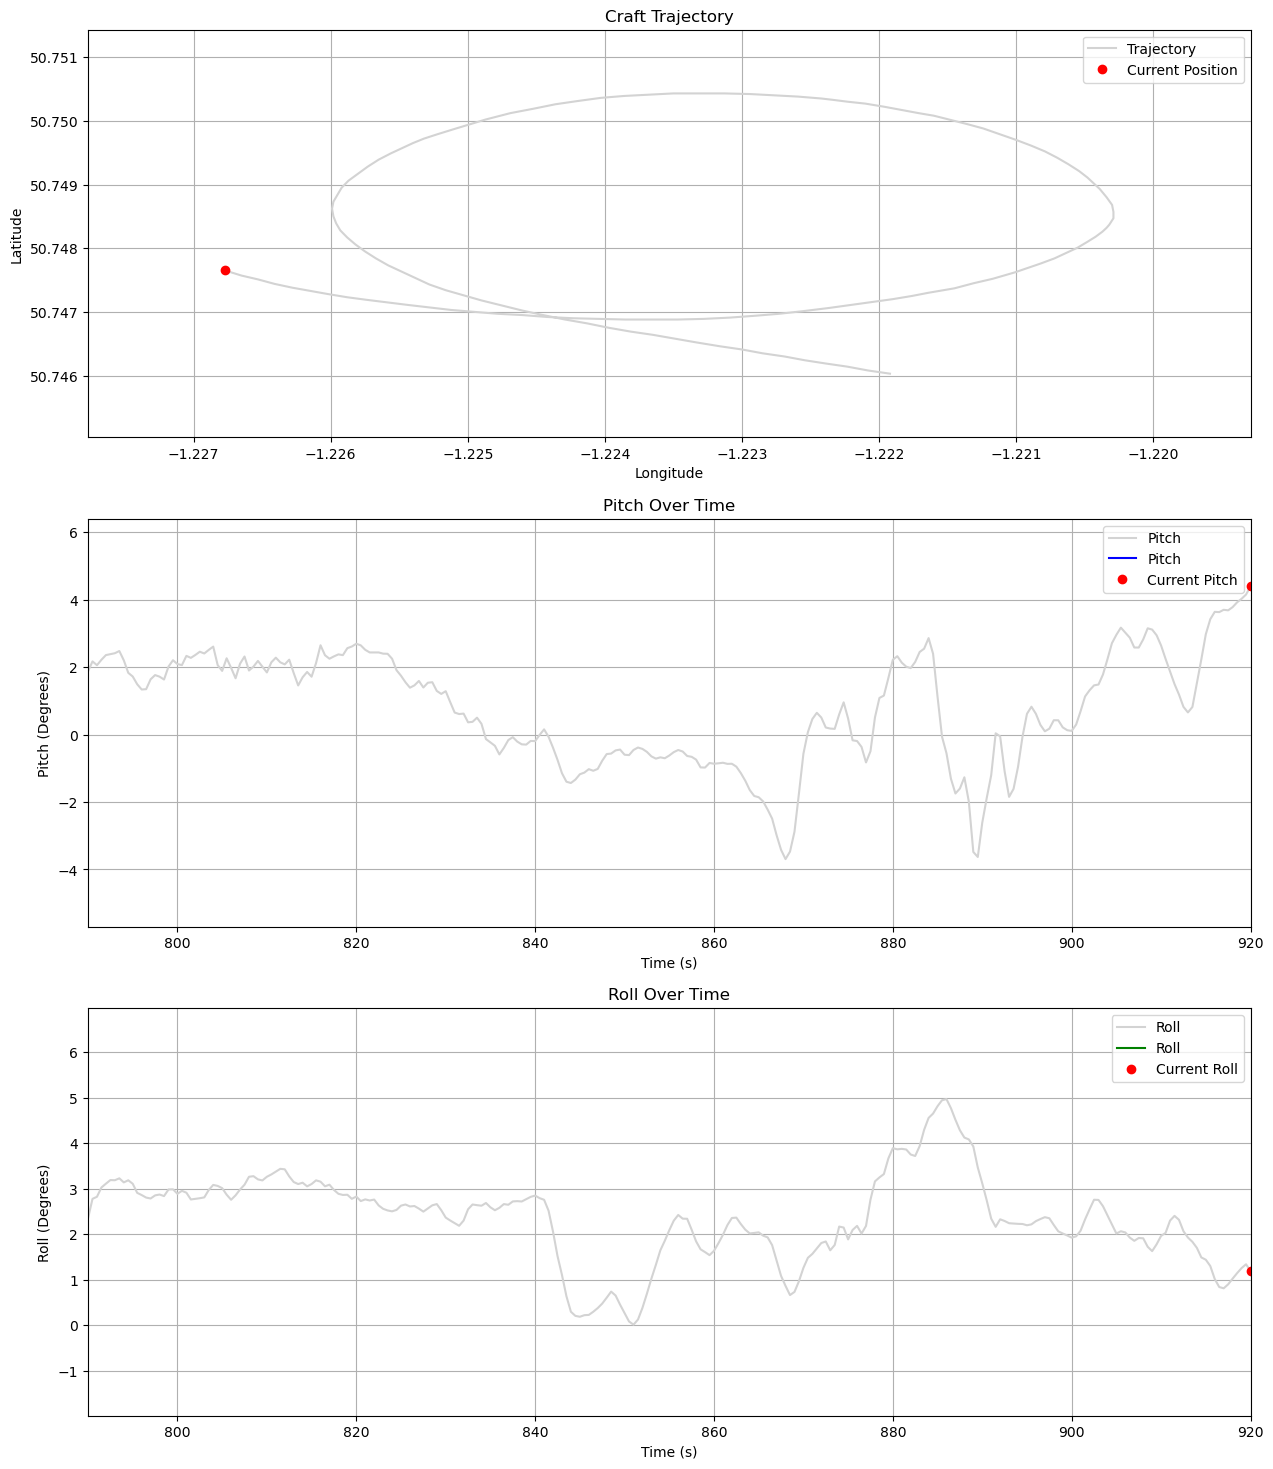

In [22]:
# [Your existing code up to the Pose Estimation section]

# =============================================================================
# Optimized Animation Section
# =============================================================================

import matplotlib.animation as animation
import matplotlib.pyplot as plt

# Check if 'Lng' and 'Lat' columns exist in data_df
if 'Lng' not in data_df.columns or 'Lat' not in data_df.columns:
    print("Error: 'Lng' and/or 'Lat' columns not found in data_df. Ensure GPS data is merged correctly.")
else:
    # =============================================================================
    # Data Downsampling
    # =============================================================================
    # Define a downsampling factor
    downsample_factor = 100  # Adjust this value based on your data size

    # Downsample the data by selecting every 'downsample_factor'-th row
    data_df_downsampled = data_df.iloc[::downsample_factor].reset_index(drop=True)

    # Extract necessary columns for animation
    traj_x = data_df_downsampled['Lng']
    traj_y = data_df_downsampled['Lat']
    pitch = data_df_downsampled['pitch_smooth']
    roll = data_df_downsampled['roll_smooth']
    time = data_df_downsampled['time_from_sync']

    # =============================================================================
    # Setup Figure and Subplots
    # =============================================================================
    fig, axs = plt.subplots(3, 1, figsize=(15, 18))

    # Subplot 1: Trajectory (Lng vs Lat)
    axs[0].plot(traj_x, traj_y, color='lightgray', label='Trajectory')
    traj_point, = axs[0].plot([], [], 'ro', label='Current Position')
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')
    axs[0].set_title('Craft Trajectory')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Pitch over Time
    axs[1].plot(time, pitch, color='lightgray', label='Pitch')
    pitch_line, = axs[1].plot([], [], 'b-', label='Pitch')
    pitch_point, = axs[1].plot([], [], 'ro', label='Current Pitch')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Pitch (Degrees)')
    axs[1].set_title('Pitch Over Time')
    axs[1].legend()
    axs[1].grid(True)

    # Subplot 3: Roll over Time
    axs[2].plot(time, roll, color='lightgray', label='Roll')
    roll_line, = axs[2].plot([], [], 'g-', label='Roll')
    roll_point, = axs[2].plot([], [], 'ro', label='Current Roll')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Roll (Degrees)')
    axs[2].set_title('Roll Over Time')
    axs[2].legend()
    axs[2].grid(True)

    # Set limits for trajectory plot
    margin = 0.001  # Adjust as needed
    axs[0].set_xlim(traj_x.min() - margin, traj_x.max() + margin)
    axs[0].set_ylim(traj_y.min() - margin, traj_y.max() + margin)

    # Set limits for pitch and roll plots
    axs[1].set_xlim(time.min(), time.max())
    axs[1].set_ylim(pitch.min() - 2, pitch.max() + 2)

    axs[2].set_xlim(time.min(), time.max())
    axs[2].set_ylim(roll.min() - 2, roll.max() + 2)

    # =============================================================================
    # Initialization Function
    # =============================================================================
    def init():
        traj_point.set_data([], [])
        pitch_point.set_data([], [])
        roll_point.set_data([], [])
        return traj_point, pitch_point, roll_point

    # =============================================================================
    # Update Function
    # =============================================================================
    def update(frame):
        # Update trajectory point
        traj_point.set_data(traj_x.iloc[frame], traj_y.iloc[frame])

        # Update pitch point
        pitch_point.set_data(time.iloc[frame], pitch.iloc[frame])

        # Update roll point
        roll_point.set_data(time.iloc[frame], roll.iloc[frame])

        return traj_point, pitch_point, roll_point

    # =============================================================================
    # Create Animation
    # =============================================================================
    # Number of frames after downsampling
    num_frames = len(data_df_downsampled)

    # Create animation
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=num_frames,
        init_func=init,
        blit=True,
        interval=20,  # milliseconds between frames
        repeat=False
    )

    # =============================================================================
    # Save the Animation
    # =============================================================================
    # Save the animation as an MP4 file using FFmpeg
    try:
        ani.save('craft_animation.mp4', writer='ffmpeg', fps=30)
        print("Animation saved as 'craft_animation.mp4' in the current working directory.")
    except Exception as e:
        print("Error saving animation:", e)
        print("Ensure that FFmpeg is installed and added to your system's PATH.")

    # =============================================================================
    # Optional: Display the Animation Inline (e.g., in Jupyter Notebook)
    # =============================================================================
    # Uncomment the following lines if you're running this in a Jupyter environment
    # from IPython.display import HTML
    # HTML(ani.to_html5_video())


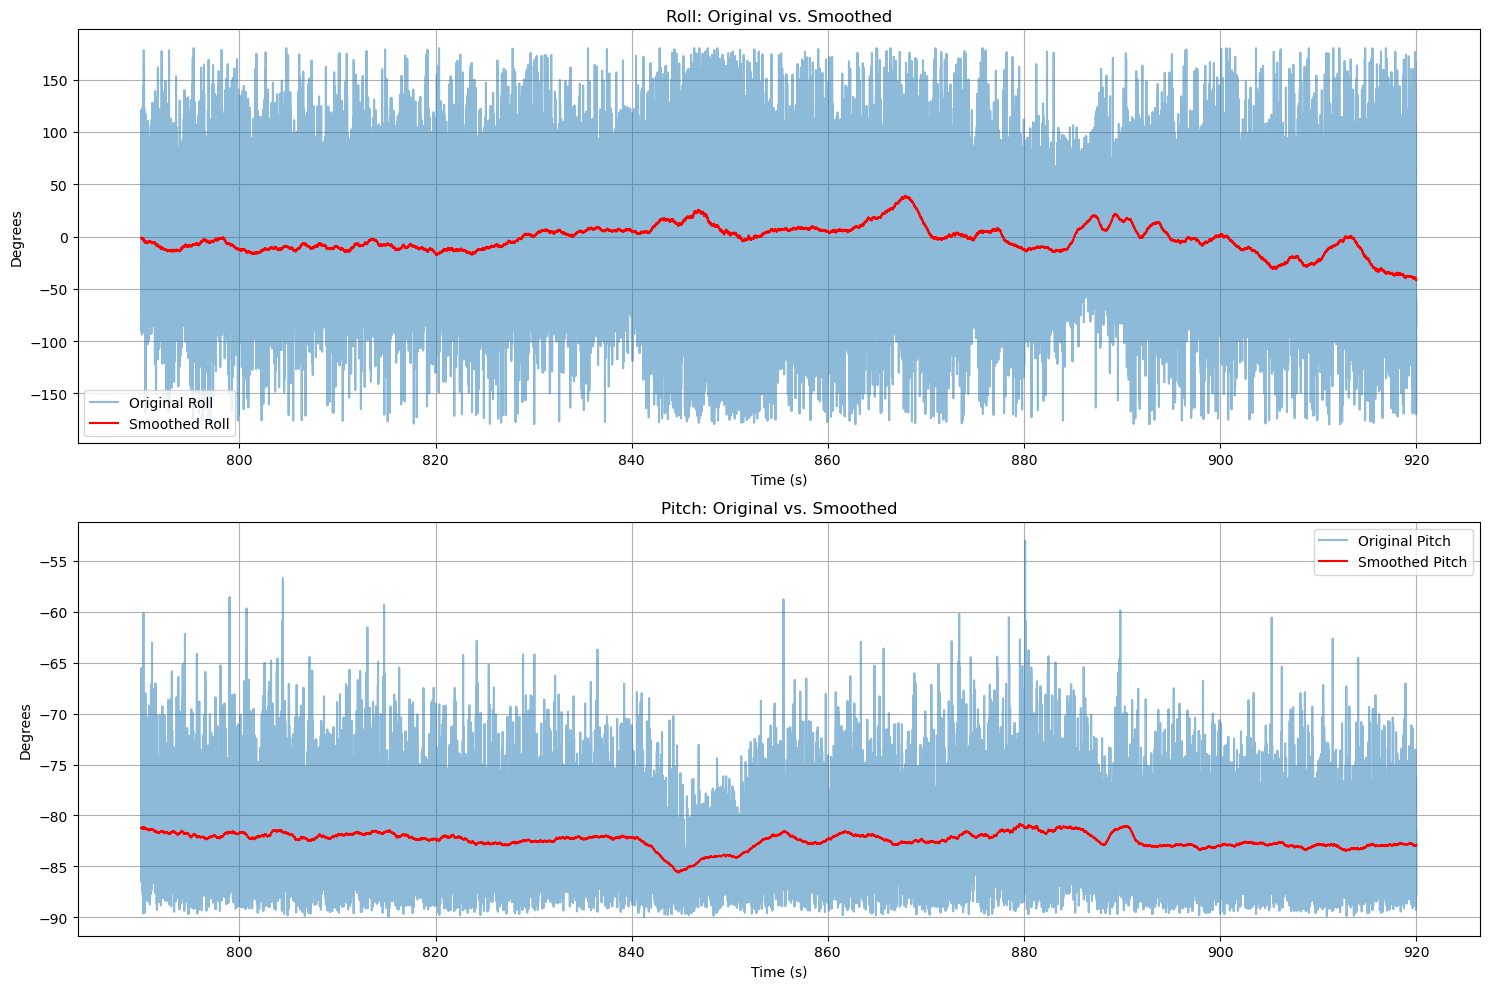

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define file paths
BASE_DIR = '007_Fast_stbd_turn_1'
IMU_DIR = os.path.join(BASE_DIR, 'IMU', 'Sensor_3')
ACCEL_FILE = os.path.join(IMU_DIR, 'accel_007_Fast_stbd_turn_1.csv')

# Define IMU columns
imu_columns = ['t', 'x', 'y', 'z', 'time_from_sync']

# Load Accelerometer data
def load_accel_data(file_path):
    """
    Loads and preprocesses accelerometer data.
    
    Parameters:
    - file_path (str): Path to the accelerometer CSV file.
    
    Returns:
    - pd.DataFrame: Preprocessed accelerometer data.
    """
    df = pd.read_csv(file_path, usecols=imu_columns)
    df = df.rename(columns={
        'x': 'accel_x',
        'y': 'accel_y',
        'z': 'accel_z'
    })
    # Drop the 't' column to avoid duplication
    df = df.drop(columns=['t'])
    return df

accel_df = load_accel_data(ACCEL_FILE)

# Calculate Pitch and Roll from Accelerometer Data
def calculate_pitch_roll(df):
    """
    Calculates pitch and roll angles from accelerometer data.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'accel_x', 'accel_y', 'accel_z'.
    
    Returns:
    - pd.DataFrame: DataFrame with added 'pitch' and 'roll' columns.
    """
    # Normalize the accelerometer data
    accel_norm = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)
    df['accel_norm'] = accel_norm
    df['accel_x_norm'] = df['accel_x'] / df['accel_norm']
    df['accel_y_norm'] = df['accel_y'] / df['accel_norm']
    df['accel_z_norm'] = df['accel_z'] / df['accel_norm']
    
    # Calculate pitch and roll in degrees
    df['pitch'] = np.degrees(np.arcsin(-df['accel_x_norm']))
    df['roll'] = np.degrees(np.arctan2(df['accel_y_norm'], df['accel_z_norm']))
    
    return df

accel_df = calculate_pitch_roll(accel_df)

# Apply Moving Average Smoothing
def moving_average(data, window_size):
    """
    Applies a moving average filter to the input data.
    
    Parameters:
    - data (pd.Series): The data to be smoothed.
    - window_size (int): The number of samples to include in each average.
    
    Returns:
    - pd.Series: The smoothed data.
    """
    return data.rolling(window=window_size, min_periods=1, center=True).mean()

# Define window size (e.g., 500 samples)
window_size = 500

# Apply smoothing to pitch and roll
accel_df['pitch_smooth'] = moving_average(accel_df['pitch'], window_size)
accel_df['roll_smooth'] = moving_average(accel_df['roll'], window_size)

# Plot Original vs. Smoothed Roll and Pitch
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(accel_df['time_from_sync'], accel_df['roll'], label='Original Roll', alpha=0.5)
plt.plot(accel_df['time_from_sync'], accel_df['roll_smooth'], label='Smoothed Roll', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Degrees')
plt.title('Roll: Original vs. Smoothed')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(accel_df['time_from_sync'], accel_df['pitch'], label='Original Pitch', alpha=0.5)
plt.plot(accel_df['time_from_sync'], accel_df['pitch_smooth'], label='Smoothed Pitch', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Degrees')
plt.title('Pitch: Original vs. Smoothed')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
